# Oligopoly

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# import all of our files
import sys
sys.path.append('../')

import fico
import support_functions as sf

#main model classses
from market import Market
from bank import Bank
from customer_group import Customer_group

DATA_DIR = '../data/'

# set plotting parameters
sns.set_context("talk")
sns.set_style("white")

# this needs to be here so we can edit figures later
plt.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


# Variables

In [2]:
### Simulation settings ###
time_steps = 100

### Market setting ###
score_range = [300,850]
repay_score = 75
default_score = -150

#this correspends to selection rate(perfect competition [0,1])
plane_range = [0, 1]
plane_slice_step = 0.01

#initial interest rate setting
initial_interest_rate_range = [0.15, 0.1]

#demand and supply interest rate boundaries
max_interest_rate_range = [0.3, 0.2]
min_interest_rate_range = [0.03, 0.02]

#policy
selected_policy = 2  #0=MU, 1=DP , 2=EO 
policy_names = ["Max. utility", "Dem. parity", "Equal opportunity" ]
policy_colors = ['green', 'blue', 'red']

### Bank setting ###
#number of banks in the market
N_banks = 3

#use unique names
bank_names = ["reference", "conservative", "risk taking"]
bank_line_style = ['-.','--', ':']
bank_color = ['red', 'blue', 'green']

#score distribution shift
score_shifts = [0, -25, 50]

#bank interest rate setting
interest_range_reference_bank = [0.15, 0.06]
interest_range_conservative_bank = [0.18, 0.04]
interest_range_risk_bank = [0.1, 0.08]
interest_change_up = 0.01
interest_change_down = -0.01
bank_interest_rate_ranges = [interest_range_conservative_bank, interest_range_risk_bank]

# profit and impact for banks (same for every bank, but different profit and impact can be set for each bank and model different revenue/cost "function")
utility_repaid = 1
utility_default = -4

### Customer groups setting ###
#use unique names
group_names = ["White","Black"]
group_colors = ['grey', 'black']
group_line_style = ['-',':']

#maximal interest rate which are customers willing to accept(linear from score 300-850)
interest_rate_limit = 0.3

#estimated number of customers in each group
white_totals = 8800
black_totals = 1200
loan_demand = 0.1

error_rate = 0.5
score_error = 150

# Prepare initial data

In [3]:
all_cdfs, performance, totals = fico.get_FICO_data(data_dir=DATA_DIR);
cdfs = all_cdfs[group_names]
cdf_groups = np.transpose(cdfs.values)

scores = cdfs.index
scores_list = scores.tolist()
scores_repay = cdfs.index

repays = performance[group_names]

totals = fico.read_totals(data_dir=DATA_DIR)
##### comment to use dataset totals (too many people)
totals['White'] = white_totals
totals['Black'] = black_totals
####
group_totals = np.zeros(len(group_names), dtype=np.int32)
for i in range(0,len(group_names)):
    group_totals[i] = int(totals[group_names[i]])

pis = np.zeros(cdf_groups.shape)
customer_totals = np.zeros(len(group_names), dtype=np.int32)

for i in range(0, len(group_names)): 
    pis[i] = sf.get_pmf(cdf_groups[i])
    customer_totals[i] = np.sum(np.round(pis[i]*group_totals[i]))
print("Reference group totals: " + str(group_totals))
print("Calculated group totals: " + str(customer_totals))

#demographic statistics 
group_ratio = np.array((customer_totals[0], customer_totals[1]))
group_size_ratio = group_ratio/group_ratio.sum()
print("Group size ratio: " + str(group_size_ratio))

pis_total = np.round(pis*group_totals[:, None])

ref_customer_scores = sf.get_ref_customers(customer_totals, pis_total, scores_list)

Reference group totals: [8800 1200]
Calculated group totals: [8805 1193]
Group size ratio: [ 0.88067614  0.11932386]


../fico.py:63: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  cdfs = cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[0]))
../fico.py:64: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  performance = 100 - cleanup_frame(pd.DataFrame.from_csv(data_dir + filenames[1]))
../fico.py:28: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  frame = cleanup_frame(pd.DataFrame.from_csv(data_dir + FILES['overview']))


# Create Model

In [4]:
#create market
market = Market(policy_names[selected_policy], policy_colors[selected_policy], score_range = score_range ,repay_score = repay_score, default_score = default_score, max_interest_rate_range = max_interest_rate_range, min_interest_rate_range = min_interest_rate_range, plane_range= plane_range, plane_slice_step = plane_slice_step)

#create banks
reference_bank = Bank(bank_names[0], bank_color[0],bank_line_style[0], interest_range_reference_bank, market, score_shift=score_shifts[0], utility_repaid=utility_repaid, utility_default = utility_default)
conservative_bank = Bank(bank_names[1], bank_color[1], bank_line_style[1], interest_range_conservative_bank, market, score_shift=score_shifts[1], utility_repaid=utility_repaid, utility_default = utility_default)
risk_taking_bank = Bank(bank_names[2], bank_color[2], bank_line_style[2], interest_range_risk_bank, market, score_shift=score_shifts[2], utility_repaid=utility_repaid, utility_default = utility_default)
banks=[reference_bank, conservative_bank, risk_taking_bank]

#create groups
white_group = Customer_group(group_names[0], group_colors[0], group_line_style[0], customer_totals[0], ref_customer_scores[0], loan_demand, 0, 0, market, repays, interest_rate_limit=interest_rate_limit)
black_group = Customer_group(group_names[1], group_colors[1], group_line_style[1], customer_totals[1], ref_customer_scores[1], loan_demand, error_rate, score_error, market, repays, interest_rate_limit=interest_rate_limit)
groups = [white_group, black_group]

### Init model values

In [5]:

for bank in banks:
    market.max_irates[bank.name] = []
    market.min_irates[bank.name] = []
    market.max_irates[bank.name].append(bank.interest_rate_range[0])
    market.min_irates[bank.name].append(bank.interest_rate_range[1])

    for group in groups:
        bank.N_loan_curves[group.name] = []
        bank.total_utility_curves[group.name] = []

group_mean_score_change_curve = {}
total_loans = {}
total_utility = {}
for group in groups:      
    group_mean_score_change_curve[group.name] = [0]
    market.loans[group.name] = [0]
    market.utility[group.name] = [0]
    total_loans[group.name] = 0
    total_utility[group.name] = 0

# Next step

In [6]:
for time in range(0, time_steps):
    print("############### STEP "+ str(market.step) + " -> " + str(market.step+1) + " ##################" )
    utilities = {}
    utility_curves = {}
    N_loans = {}
    step_loans = 0
    step_customers = 0
    
    ### Before ###            
    selection_rates, max_util = market.get_selection_rate(banks, groups)
    for bank in banks:
        bank.set_selection_rate(selection_rates[bank.name])
        utilities[bank.name] = {}
        utility_curves[bank.name] = {}
        N_loans[bank.name] = {}

    ### During ###
    for group in groups:
        for bank in banks:
            utilities[bank.name][group.name] = 0
            utility_curves[bank.name][group.name] = []
            N_loans[bank.name][group.name] = 0
            
        #select part of customer base at random according to group loan demand
        customers = np.sort(random.sample(range(0, group.size), int(group.size*group.loan_demand)))
        step_customers += len(customers) 
        #go over all selected customers in the group
        for j in customers:
            best_bank = None
            best_interest_rate = np.Infinity
            
            # check which bank gives best interest rate
            for k in range(len(banks)):
                if j/group.size <= banks[k].group_selection_rate[group.name]:
                    expected_customer_score = banks[k].get_expected_customer_score(market, group.scores[j])
                    interest_rate = banks[k].score_interest_rates[expected_customer_score]
                    if interest_rate < best_interest_rate and interest_rate < group.interest_rate_limit:
                        best_interest_rate = interest_rate
                        best_bank = k

            #print(best_bank)
            if best_bank is not None:                
                #get loan outcome and change score
                step_loans += 1
                total_loans[group.name] += 1
                N_loans[banks[best_bank].name][group.name] += 1 
                real_customer_score = group.real_scores[j]
                loan_outcome = group.get_repay_outcome(group.score_repay_prob[real_customer_score])
                expected_customer_score = banks[best_bank].get_expected_customer_score(market, group.scores[j])
                group.change_score(market, j, loan_outcome)
                group.change_real_score(market, j, loan_outcome)
                
                #get bank utility
                interest_rate = banks[best_bank].score_interest_rates[group.scores[j]]
                utility_change = banks[best_bank].get_customer_utility(interest_rate, loan_outcome)
                utilities[banks[best_bank].name][group.name] += utility_change
                total_utility[group.name] += utility_change
                utility_curves[banks[best_bank].name][group.name].append(utilities[banks[best_bank].name][group.name])           
 
        for bank in banks:
            if market.step == 0:
                bank.N_loan_curves[group.name].append(N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(utilities[bank.name][group.name])
            else:
                bank.N_loan_curves[group.name].append(bank.N_loan_curves[group.name][-1] + N_loans[bank.name][group.name])
                bank.total_utility_curves[group.name].append(bank.total_utility_curves[group.name][-1] + utilities[bank.name][group.name])        
        group.sort_scores()
        group_mean_score_change_curve[group.name].append(group.get_mean_score_change())
        print(group.name + " group mean score change: " + str(group.get_mean_score_change()))
    
    market.step += 1 
    
    ### After ###
    #adjust interest rate, we will need market share and utilities for this
    for bank in banks:

        bank_clients = 0
        total_clients = 0
        max_expected_utility = 0
        real_utility = 0
        #calculate market share and utilities
        for group in groups:
            bank.real_group_utility_curve[group.name] = utility_curves[bank.name][group.name]
            total_clients += group.size * group.loan_demand * bank.group_selection_rate[group.name]
            bank_clients += len(bank.real_group_utility_curve[group.name])   
            max_expected_utility += np.max(bank.expected_group_utility_curve[group.name])* group.loan_demand

            if len(bank.real_group_utility_curve[group.name])>0:
                real_utility += bank.real_group_utility_curve[group.name][-1]                                   

        bank.market_share = bank_clients/total_clients 
        #change interest rate according to actual market share and utility
        if bank.market_share >= 1/len(banks) and real_utility >= max_expected_utility/len(banks):
            bank.change_interest_rate(interest_change_up, market)
        elif bank.market_share < 1/len(banks):
            bank.change_interest_rate(interest_change_down, market)
        
        print(bank.name + " bank - Market share: "  + str(bank.market_share) + ", Interest rate: " + str(bank.interest_rate_range))   
        
        market.max_irates[bank.name].append(bank.interest_rate_range[0])
        market.min_irates[bank.name].append(bank.interest_rate_range[1])
    
    for group in groups:
        market.loans[group.name].append(total_loans[group.name])
        market.utility[group.name].append(total_utility[group.name])

    market.plot_market_situation_oligo(banks, groups, group_mean_score_change_curve)

############### STEP 0 -> 1 ##################
White group mean score change: 3.89119818285
Black group mean score change: 0.817267393127
reference bank - Market share: 0.0, Interest rate: [0.14, 0.05]
conservative bank - Market share: 0.632822139961, Interest rate: [0.19, 0.05]
risk taking bank - Market share: 0.500479912245, Interest rate: [0.1, 0.08]
Loans - White: 666, Utility - White: 0.659546546547
Loans - Black: 58, Utility - Black: -0.231551724138
Loans - Total: 724.0, Utility - Total: 0.588160220994



../market.py:294: RuntimeWarning: invalid value encountered in true_divide
  ax[2][1].plot(list(range(len(self.utility[group.name]))), np.array(self.utility[group.name])/np.array(self.loans[group.name]), color = group.color, LineStyle = group.line_style,label = "Total utility per loan for "+ group.name + " group")
../market.py:305: RuntimeWarning: invalid value encountered in true_divide
  ax[2][1].plot(list(range(len(total_utility))), np.array(total_utility)/np.array(total_loans), color="red",label= "Total utility per loan")


############### STEP 1 -> 2 ##################
White group mean score change: 7.52981260647
Black group mean score change: 1.71500419111
reference bank - Market share: 0.939980946332, Interest rate: [0.15, 0.06]
conservative bank - Market share: 0.0, Interest rate: [0.18, 0.04]
risk taking bank - Market share: 0.189200386687, Interest rate: [0.09, 0.07]
Loans - White: 1335, Utility - White: 0.644602696629
Loans - Black: 118, Utility - Black: -0.213676271186
Loans - Total: 1453.0, Utility - Total: 0.574900757054

############### STEP 2 -> 3 ##################
White group mean score change: 11.114366837
Black group mean score change: 1.95222129086
reference bank - Market share: 0.0, Interest rate: [0.14, 0.05]
conservative bank - Market share: 0.467866323907, Interest rate: [0.18, 0.04]
risk taking bank - Market share: 0.624477279063, Interest rate: [0.09, 0.07]
Loans - White: 1993, Utility - White: 0.664841495233
Loans - Black: 181, Utility - Black: -0.299524861878
Loans - Total: 2174.0

############### STEP 17 -> 18 ##################
White group mean score change: 51.1829642249
Black group mean score change: 22.0184409053
reference bank - Market share: 0.697887970615, Interest rate: [0.13, 0.04]
conservative bank - Market share: 0.0, Interest rate: [0.17, 0.03]
risk taking bank - Market share: 0.346046237668, Interest rate: [0.06, 0.04]
Loans - White: 11630, Utility - White: 0.802555958727
Loans - Black: 1036, Utility - Black: 0.137884459459
Loans - Total: 12666.0, Utility - Total: 0.748189965261

############### STEP 18 -> 19 ##################
White group mean score change: 52.8742759796
Black group mean score change: 23.2908633697
reference bank - Market share: 0.0, Interest rate: [0.12, 0.03]
conservative bank - Market share: 0.549159925327, Interest rate: [0.17, 0.03]
risk taking bank - Market share: 0.466528436019, Interest rate: [0.06, 0.04]
Loans - White: 12242, Utility - White: 0.808011583075
Loans - Black: 1092, Utility - Black: 0.156424450549
Loans - Total

############### STEP 33 -> 34 ##################
White group mean score change: 69.6804088586
Black group mean score change: 37.8642078793
reference bank - Market share: 0.871888837991, Interest rate: [0.13, 0.04]
conservative bank - Market share: 0.0, Interest rate: [0.17, 0.03]
risk taking bank - Market share: 0.142900120337, Interest rate: [0.05, 0.03]
Loans - White: 21542, Utility - White: 0.857777383716
Loans - Black: 1821, Utility - Black: 0.355762493136
Loans - Total: 23363.0, Utility - Total: 0.818648456962

############### STEP 34 -> 35 ##################
White group mean score change: 70.261669506
Black group mean score change: 38.4409052808
reference bank - Market share: 0.0, Interest rate: [0.12, 0.03]
conservative bank - Market share: 0.00607625702567, Interest rate: [0.17, 0.03]
risk taking bank - Market share: 0.981604342581, Interest rate: [0.06, 0.04]
Loans - White: 22150, Utility - White: 0.859104573363
Loans - Black: 1868, Utility - Black: 0.361977890792
Loans - Tota

############### STEP 49 -> 50 ##################
White group mean score change: 76.6655309483
Black group mean score change: 46.3562447611
reference bank - Market share: 0.936697386312, Interest rate: [0.13, 0.04]
conservative bank - Market share: 0.0, Interest rate: [0.17, 0.03]
risk taking bank - Market share: 0.0710184345724, Interest rate: [0.05, 0.03]
Loans - White: 31401, Utility - White: 0.890073488105
Loans - Black: 2604, Utility - Black: 0.472450345622
Loans - Total: 34005.0, Utility - Total: 0.858093171592

############### STEP 50 -> 51 ##################
White group mean score change: 76.9894378194
Black group mean score change: 46.9077954736
reference bank - Market share: 0.00904022901914, Interest rate: [0.12, 0.03]
conservative bank - Market share: 0.0, Interest rate: [0.17, 0.03]
risk taking bank - Market share: 0.98955969133, Interest rate: [0.06, 0.04]
Loans - White: 32003, Utility - White: 0.891764228353
Loans - Black: 2662, Utility - Black: 0.477143163035
Loans - Tot

Loans - White: 40582, Utility - White: 0.909396816322
Loans - Black: 3331, Utility - Black: 0.540386730711
Loans - Total: 43913.0, Utility - Total: 0.88140572951

############### STEP 65 -> 66 ##################
White group mean score change: 79.2464508802
Black group mean score change: 49.7376362112
reference bank - Market share: 1.00453172205, Interest rate: [0.13, 0.04]
conservative bank - Market share: 0.0, Interest rate: [0.17, 0.03]
risk taking bank - Market share: 0.030303030303, Interest rate: [0.05, 0.03]
Loans - White: 41213, Utility - White: 0.910637497876
Loans - Black: 3385, Utility - Black: 0.542300206795
Loans - Total: 44598.0, Utility - Total: 0.882680600026

############### STEP 66 -> 67 ##################
White group mean score change: 79.3193639977
Black group mean score change: 50.0293378039
reference bank - Market share: 0.0, Interest rate: [0.12, 0.03]
conservative bank - Market share: 0.0, Interest rate: [0.17, 0.03]
risk taking bank - Market share: 1.00045475216

Loans - White: 50453, Utility - White: 0.922458270073
Loans - Black: 4082, Utility - Black: 0.614605952964
Loans - Total: 54535.0, Utility - Total: 0.899415212248

############### STEP 81 -> 82 ##################
White group mean score change: 80.0386144236
Black group mean score change: 53.07627829
reference bank - Market share: 0.981343849537, Interest rate: [0.13, 0.04]
conservative bank - Market share: 0.00151515151515, Interest rate: [0.17, 0.03]
risk taking bank - Market share: 0.0333383846037, Interest rate: [0.05, 0.03]
Loans - White: 51074, Utility - White: 0.923178944276
Loans - Black: 4131, Utility - Black: 0.619560372791
Loans - Total: 55205.0, Utility - Total: 0.900459112399

############### STEP 82 -> 83 ##################
White group mean score change: 79.9683134583
Black group mean score change: 53.2715842414
reference bank - Market share: 0.00151676020021, Interest rate: [0.12, 0.03]
conservative bank - Market share: 0.00151653017895, Interest rate: [0.17, 0.03]
risk t

Loans - White: 60250, Utility - White: 0.930535955186
Loans - Black: 4820, Utility - Black: 0.666858713693
Loans - Total: 65070.0, Utility - Total: 0.911004307668

############### STEP 97 -> 98 ##################
White group mean score change: 79.9381033504
Black group mean score change: 54.2028499581
reference bank - Market share: 0.975905440218, Interest rate: [0.13, 0.04]
conservative bank - Market share: 0.0, Interest rate: [0.17, 0.03]
risk taking bank - Market share: 0.0272644653135, Interest rate: [0.05, 0.03]
Loans - White: 60864, Utility - White: 0.930797803298
Loans - Black: 4868, Utility - Black: 0.668385866886
Loans - Total: 65732.0, Utility - Total: 0.911364022089

############### STEP 98 -> 99 ##################
White group mean score change: 80.0156729131
Black group mean score change: 54.077116513
reference bank - Market share: 0.00151515151515, Interest rate: [0.12, 0.03]
conservative bank - Market share: 0.0, Interest rate: [0.17, 0.03]
risk taking bank - Market share

# Playing with TC, TR, MC, MR and UC

6129
1674.60318 1139.06042309
968.9184 3008.81088


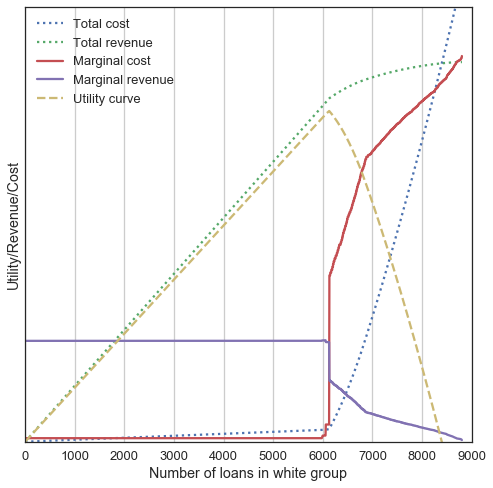

In [7]:
TC_curve = [0]
TR_curve = [0]
MC_curve = []
MR_curve = []
utility_curve = []
TC=0
TR=0
utility=0

n=0

for k in range(0, groups[n].size):
    expected_customer_score = banks[0].get_expected_customer_score(market,groups[n].scores[k])
    utility += banks[0].get_customer_evaluation_utility(expected_customer_score, groups[n])
    utility_curve.append(utility*1)
    TC += -banks[0].utility_default*(1-groups[n].score_repay_prob[expected_customer_score])
    TR += (banks[0].utility_repaid+banks[0].score_interest_rates[expected_customer_score])*groups[n].score_repay_prob[expected_customer_score]
    TC_curve.append(TC)
    TR_curve.append(TR)
    MC_curve.append((TC_curve[-1] - TC_curve[-2])*1800)
    MR_curve.append((TR_curve[-1] - TR_curve[-2])*1800)
    
plt.figure(figsize=(8,8))
plt.plot(list(range(0, len(TC_curve))),TC_curve,LineStyle=":",label="Total cost")
plt.plot(list(range(0, len(TR_curve))),TR_curve,LineStyle=":",label="Total revenue")
plt.plot(list(range(0, len(MC_curve))),MC_curve,label="Marginal cost")
plt.plot(list(range(0, len(MR_curve))),MR_curve,label="Marginal revenue")
plt.plot(list(range(0, len(utility_curve))),utility_curve,LineStyle="--",label="Utility curve")
plt.xlabel("Number of loans in white group")
plt.ylabel("Utility/Revenue/Cost")
plt.ylim(0,8000)
plt.xlim(0,9000)
plt.yticks([])
plt.grid("on")
plt.legend()
plt.show

print(utility_curve.index(max(utility_curve)))
i =utility_curve.index(max(utility_curve))
print(MR_curve[i],MR_curve[i+1])
print(MC_curve[i],MC_curve[i+1])

# Perfect competition market

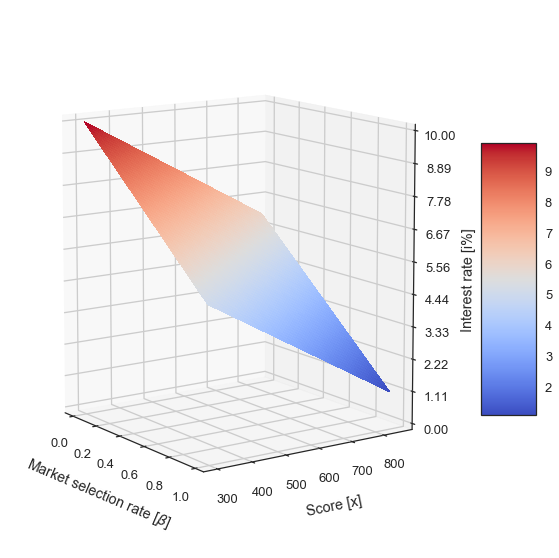

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 1, 0.01)
Y = np.arange(300, 850, 1)
X, Y = np.meshgrid(X, Y)
Z = 5-X*5 + 5-((Y-300)/550)*4 

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'Market selection rate [$\beta$]')
ax.set_ylabel('Score [x]')
ax.set_zlabel('Interest rate [i%]')
ax.view_init(elev=10., azim=-35)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
ax.zaxis.labelpad = 18


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Imperfect competition cartel market

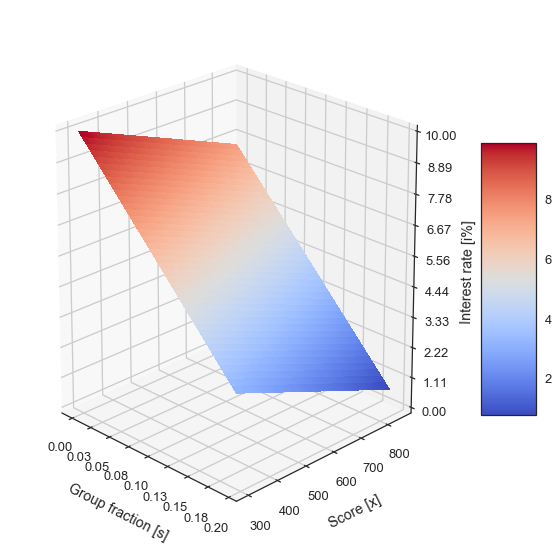

In [9]:
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 0.2, 0.005)
Y = np.arange(300, 850, 1)
X, Y = np.meshgrid(X, Y)
Z = 7-X*35 + 3 - ((Y-300)/550)*2.5 

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 10)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(r'Group fraction [s]')
ax.set_ylabel('Score [x]')
ax.set_zlabel('Interest rate [i%]')
ax.view_init(elev=20, azim=-45)
ax.xaxis.labelpad = 18
ax.yaxis.labelpad = 18
ax.zaxis.labelpad = 18


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()